In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics                    import mean_squared_error
from darts.models                       import NaiveSeasonal, ExponentialSmoothing
from darts.utils.utils                  import ModelMode,SeasonalityMode
from darts                              import TimeSeries
from sklearn.linear_model   import Lasso,Ridge

from darts.models import (
    LinearRegressionModel,
    RegressionModel,
    LightGBMModel,
    XGBModel,
    CatBoostModel,
)


In [55]:
pdf = pd.read_csv("../../data/daily/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])


split = len(pdf)-12
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]
ytrain = TimeSeries.from_dataframe(pdf_train)
ytest  = TimeSeries.from_dataframe(pdf_test)
ytotal = TimeSeries.from_dataframe(pdf)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`.To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


<Axes: xlabel='time'>

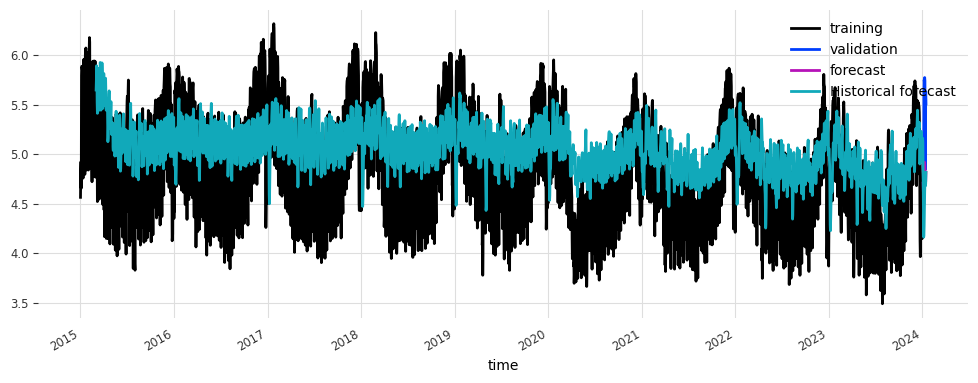

In [58]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

model = RegressionModel(
        lags=[-1,-2,-3,-6,-12],
        output_chunk_length = 1, 
        model=Ridge(),
        # lags_future_covariates=(12, 1),
        # add_encoders={"cyclic": {"future": ["month",'day','dayofweek','week_of_year']},"tz": "CET",}
        )

model.fit(ytrain)
pred = model.predict(12)

ytrain.plot(label="training")
ytest.plot(label="validation")
pred.plot(label="forecast")

yhist = model.historical_forecasts(series=ytotal, forecast_horizon=12, stride=1)
yhist[36:].plot(label='Historical forecast')

In [ ]:
from darts.metrics import mape

lgbm_model = LightGBMModel(lags=12, output_chunk_length=1)
xgboost_model = XGBModel(lags=12, output_chunk_length=1)
catboost_model = CatBoostModel(lags=12, output_chunk_length=1)

lgbm_model.fit(ytrain)
xgboost_model.fit(ytrain)
catboost_model.fit(ytrain)

pred_lgbm = lgbm_model.predict(n=12)
pred_xgboost = xgboost_model.predict(n=12)
pred_catboost = catboost_model.predict(n=12)

LightGBMModel MAPE: 2.0973368158907895
XGBoostModel MAPE: 2.676112110128233
CatboostModel MAPE: 2.8850807192976715


<Axes: xlabel='Timestamp'>

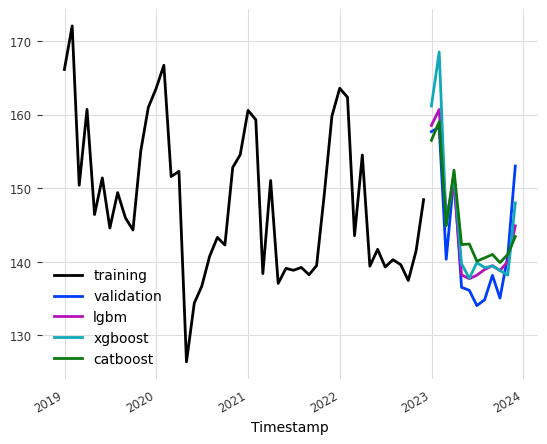

In [52]:
print(f"LightGBMModel MAPE: {mape(ytest, pred_lgbm)}")
print(f"XGBoostModel MAPE: {mape(ytest, pred_xgboost)}")
print(f"CatboostModel MAPE: {mape(ytest, pred_catboost)}")


ytrain[-48:].plot(label="training")
ytest[:24].plot(label="validation")
pred_lgbm.plot(label="lgbm")
pred_xgboost.plot(label="xgboost")
pred_catboost.plot(label="catboost")